In [1]:
!pip install bert-for-tf2

In [2]:
import pandas as pd
import numpy as np
import json
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score

In [3]:
import tensorflow as tf
import transformers
import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer 
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint

## Load Dataset

In [4]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('train.csv')
df_test = pd.read_csv('train.csv')

In [5]:
print(df_train.info())
df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [6]:
print(df_val.info())
df_val

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


<AxesSubplot:xlabel='label', ylabel='count'>

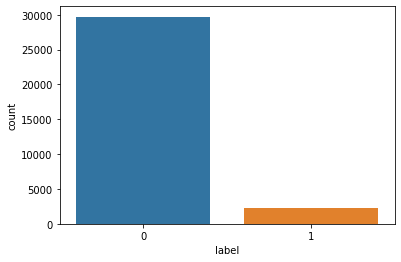

In [7]:
import seaborn as sns
sns.countplot(x="label", data = df_train)

In [8]:
print(df_test.info())
df_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


## Metrics

In [9]:
def get_metrics(y_test, y_pred_proba):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred_proba >= 0.5), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred_proba >= 0.5, average = "macro"), 4)) 
    print('ROC_AUC_SCORE: ', round(roc_auc_score(y_test, y_pred_proba), 4)) #Receiver Operating Characteristic Curve 
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred_proba >= 0.5),'\n')

In [10]:
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_punctuations(z))
df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_html(z))
df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_url(z))
df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_emoji(z))

df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_punctuations(z))
df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_html(z))
df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_url(z))
df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_emoji(z))

df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_punctuations(z))
df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_html(z))
df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_url(z))
df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_emoji(z))

In [11]:
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data)  
    return data
    
df_train['tweet'] = df_train['tweet'].apply(lambda z: remove_abb(z))
df_val['tweet'] = df_val['tweet'].apply(lambda z: remove_abb(z))
df_test['tweet'] = df_test['tweet'].apply(lambda z: remove_abb(z))

In [12]:
print(df_train.shape)
print(df_train.head(5))
print(df_val.shape)
print(df_val.head(5))
print(df_test.shape)
print(df_test.head(5))

(31962, 3)
   id  label                                              tweet
0   1      0   user when a father is dysfunctional and is so...
1   2      0  user user thanks for lyft credit i cant use ca...
2   3      0                                bihday your majesty
3   4      0  model   i love u take with u all the time in u...
4   5      0               factsguide society now    motivation
(31962, 3)
   id  label                                              tweet
0   1      0   user when a father is dysfunctional and is so...
1   2      0  user user thanks for lyft credit i cant use ca...
2   3      0                                bihday your majesty
3   4      0  model   i love u take with u all the time in u...
4   5      0               factsguide society now    motivation
(31962, 3)
   id  label                                              tweet
0   1      0   user when a father is dysfunctional and is so...
1   2      0  user user thanks for lyft credit i cant use ca...
2   3  

## Encoding 


In [13]:
class IntentDetectionData:
    DATA_COLUMN,  LABEL_COLUMN  = "tweet","label"

    def __init__(self, train, val, test, tokenizer: FullTokenizer, classes, max_seq_len):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.val_x, self.val_y), (self.test_x, self.test_y)) = map(self._prepare, [train, val, test])

        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.val_x, self.test_x = map(self._pad, [self.train_x, self.val_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
    
        for non, row in tqdm(df.iterrows()):
            text, label =\
                row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]

            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"] ## Tokens beigning and ending specified by separation of tokens.

            token_ids = self.tokenizer.convert_tokens_to_ids(tokens) ## Convert Tokens to IDs

            self.max_seq_len = max(self.max_seq_len, len(token_ids))

            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)] ## -2 as ignoring tokens provided by bert
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids)) ## padding by zeros
            x.append(np.array(input_ids))
        
        return np.array(x)

## Model


## CNN

In [14]:
def CNN_V0(bert_output):
    net = Conv1D(128, 7, activation='relu',padding='same')(bert_output)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

### BiLSTM

In [15]:
def BiLSTM_V0(bert_output):
    net = Bidirectional(LSTM(units=32, return_sequences=True,))(bert_output)
    net = GlobalAveragePooling1D()(net)
    net = Dense(20, activation='relu')(net)
    net = Dropout(rate=0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

In [16]:
def LSTM_V0(bert_output):
    net = LSTM(units=32, return_sequences=True,)(bert_output)
    net = GlobalAveragePooling1D()(net)
    net = Dense(20, activation='relu')(net)
    net = Dropout(rate=0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

### CNN + LSTM

In [17]:
def CNN_LSTM_V0(bert_output):
    net = Dropout(0.3)(bert_output)
    net = Conv1D(200, 5, activation='relu')(net)
    net = MaxPooling1D(pool_size=2)(net)
    net = LSTM(100)(net)
    net = Dropout(0.3)(net)
    net = Dense(16,activation='relu')(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net)
    return outputs

In [18]:
def CNN_LSTM_V1(bert_output):

    # channel 1
    net = Conv1D(filters=128, kernel_size=3*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    a = LSTM(128)(net)

    # channel 2
    net = Conv1D(filters=128, kernel_size=5*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    b = LSTM(128)(net)

    # channel 3
    net = Conv1D(filters=128, kernel_size=7*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    c = LSTM(128)(net)

    # channel 4
    net = Conv1D(filters=128, kernel_size=9*32, activation='relu')(bert_output)
    net = MaxPooling1D(pool_size=2)(net)
    net = Dropout(0.5)(net)
    net = BatchNormalization()(net)
    d = LSTM(128)(net)

    merged = concatenate([a,b,c,d])
    dense = Dense(100, activation='relu')(merged)
    drop = Dropout(0.2)(dense)
    outputs = Dense(1, activation='sigmoid')(merged)
    return outputs

## LSTM + CNN

In [19]:
def LSTM_CNN_V0(bert_output):
    net = Bidirectional(LSTM(128, return_sequences=True))(bert_output)
    net = Conv1D(128, 7, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(256, 5, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Conv1D(512, 3, activation='relu',padding='same')(net)
    net = MaxPooling1D()(net)
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    net = Dropout(0.5)(net)
    outputs = Dense(1, activation='sigmoid', name='classifier')(net) 
    return outputs

In [20]:
def create_model(model_name, model_ver, max_seq_len, bert_checkpnt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read()) ## Reading bert config
        bert_params = map_stock_config_to_params(bc) ## Mapping parameters 
        bert_params.adapter_size = None # Adapter size helps tune Bert model faster
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    ## Creat dictionary
    choose_model = {'CNN':{0: CNN_V0},
                    'BiLSTM':{0: BiLSTM_V0},
                    'LSTM':{0: LSTM_V0},
                    'CNN+LSTM':{0: CNN_LSTM_V0, 1: CNN_LSTM_V1},
                    'LSTM+CNN':{0: LSTM_CNN_V0},}
    
    ## Specifying input
    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)
        
    outputs = choose_model[model_name][model_ver](bert_output)

    model = keras.Model(input_ids, outputs)
    model.build(input_shape=(None, max_seq_len))
    load_stock_weights(bert, bert_checkpnt_file) ##Loading the weights from bert chckpoint file
        
    return model

## BERT GCN

In [21]:
bert_model_name = "uncased_L-12_H-768_A-12"
# uncased_L-4_H-512_A-8
# uncased_L-12_H-768_A-12

#!wget  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip
#!unzip {bert_model_name}.zip

In [22]:
bert_model_path = "./"
bert_checkpnt_file = os.path.join(bert_model_path, "bert_model.ckpt")
bert_config_file = os.path.join(bert_model_path, "bert_config.json")
bert_vocab_file = os.path.join(bert_model_path, "vocab.txt")
print(bert_checkpnt_file)
print(bert_config_file)
print(bert_vocab_file)

./bert_model.ckpt
./bert_config.json
./vocab.txt


## Data Pretrain

In [23]:
# Tokenize
tokenizer = FullTokenizer(vocab_file=bert_vocab_file)
tokens = tokenizer.tokenize("People say nothing is impossible, but I do nothing everyday")
print(tokens)
tokenizer.convert_tokens_to_ids(tokens)

['people', 'say', 'nothing', 'is', 'impossible', ',', 'but', 'i', 'do', 'nothing', 'everyday']


[2111, 2360, 2498, 2003, 5263, 1010, 2021, 1045, 2079, 2498, 10126]

In [24]:
classes = [0, 1]
max_seq_len = 72
data = IntentDetectionData(df_train, df_val, df_test, tokenizer, classes, max_seq_len)
print(data.max_seq_len)

31962it [00:11, 2857.55it/s]
31962it [00:09, 3267.24it/s]
31962it [00:09, 3201.40it/s]


72
